# Set Up

## Only Once

In [ ]:
!pip install -r https://raw.githubusercontent.com/huggingface/deep-rl-class/main/notebooks/unit2/requirements-unit2.txt

!sudo apt-get update
!sudo apt-get install -y python3-opengl ffmpeg xvfb

!pip3 install pyvirtualdisplay

import os
os.kill(os.getpid(), 9)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.1/132.1 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 757.9/757.9 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 39.8 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pickle5
  Running setup.py clean for pickle5
Failed to build pickle5
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (pickle5)
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/u

---

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pickle
import tqdm
from tqdm.notebook import tqdm
import random
import imageio
import os
from pathlib import Path
import datetime
import json

# Gym environment
import gymnasium as gym

# Hugging Face
from huggingface_hub import notebook_login
from huggingface_hub import HfApi, snapshot_download
from huggingface_hub.repocard import metadata_eval_result, metadata_save

# Virtual display
from pyvirtualdisplay import Display
from IPython.display import display

virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

---

# Frozen Lake Environment

#### **Action Space**

The environment has **four discrete actions** that can be taken:

- **0**: Move left
- **1**: Move down
- **2**: Move right
- **3**: Move up

These actions control the player's movement on the frozen lake grid.

#### **Observation Space**

The observation is represented as a **single integer** corresponding to the player's current position, calculated as:

- **current_row * ncols + current_col**

Where both `row` and `col` start at 0.

The number of possible observations depends on the size of the map. For the 4x4 map, there are 16 possible states.


## Bibliography

For further information on the Frozen Lake environment, please refer to the official documentation provided by Gymnasium:

- [Frozen Lake - Gymnasium Documentation](https://gymnasium.farama.org/environments/toy_text/frozen_lake/)

---

## Random Actions Testing

_____OBSERVATION SPACE_____ 

Observation Space Shape Discrete(16)
Sample observation 7
_____________________________

 _____ACTION SPACE_____ 

Action Space Shape 4
Action Space Sample 1
__________________________________________ 


_____OBSERVATION SPACE_____ 

Observation Space Shape Discrete(16)
Sample observation 4
_____________________________

 _____ACTION SPACE_____ 

Action Space Shape 4
Action Space Sample 0
__________________________________________ 


_____OBSERVATION SPACE_____ 

Observation Space Shape Discrete(16)
Sample observation 6
_____________________________

 _____ACTION SPACE_____ 

Action Space Shape 4
Action Space Sample 2
__________________________________________ 


Environment reset!
_____OBSERVATION SPACE_____ 

Observation Space Shape Discrete(16)
Sample observation 11
_____________________________

 _____ACTION SPACE_____ 

Action Space Shape 4
Action Space Sample 0
__________________________________________ 


_____OBSERVATION SPACE_____ 

Observation Sp

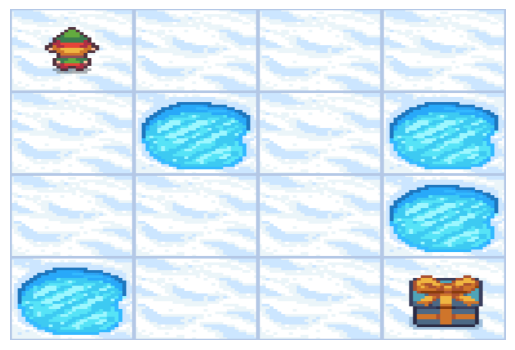

In [2]:
# Create the environment
env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=False, render_mode="rgb_array")

observation, info = env.reset()

frames = []

# Capture frames for 100 steps
for _ in range(100):
    action = env.action_space.sample()  # Random action
    observation, reward, terminated, truncated, info = env.step(action)  # Perform action

    frame = env.render()
    frames.append(frame)  # Save frame

    print("_____OBSERVATION SPACE_____ \n")
    print("Observation Space Shape", env.observation_space)
    print("Sample observation", env.observation_space.sample())
    print("_____________________________")

    print("\n _____ACTION SPACE_____ \n")
    print("Action Space Shape", env.action_space.n)
    print("Action Space Sample", action)

    print("__________________________________________ \n\n")

    # Reset the environment if needed
    if terminated or truncated:
        print("Environment reset!")
        observation, info = env.reset()

# Close at the end
env.close()

fig, ax = plt.subplots()
img = ax.imshow(np.zeros((400, 600, 3), dtype=np.uint8))
ax.axis('off')

def update_frame(frame):
    img.set_data(frame)
    return [img]

# Create animation
ani = animation.FuncAnimation(fig, update_frame, frames=frames, interval=100, blit=True)

# Save animation
ani.save('frozen_lake_random.mp4', writer='ffmpeg', fps=20)

# display(fig)

# Stop the virtual display at the end
virtual_display.stop()


---

## Q-Learning

In [3]:
state_space = env.observation_space.n
print(f"Possible states: {state_space}")

action_space = env.action_space.n
print(f"Possible actions: {action_space}")

Possible states: 16
Possible actions: 4


In [4]:
def initalize_q_table(state_space, action_space):
  q_table = np.zeros((state_space, action_space))
  return q_table

In [9]:
q_table_frozen = initalize_q_table(state_space, action_space)
q_table_frozen.shape

(16, 4)

In [15]:
def greedy_policy(q_table, state):
    action = np.argmax(q_table[state][:])  # Select the action with the highest Q-value
    return action

def epsilon_greedy_policy(q_table, state, epsilon):
    random_num = random.uniform(0, 1)

    if random_num > epsilon:
        # Greedy policy
        action = greedy_policy(q_table, state)
    else:
        # Random action
        action = env.action_space.sample()

    return action

In [42]:
# Training parameters
n_training_episodes = 100000  # Total training episodes
learning_rate = 0.2  # Learning rate

# Eval parameters
n_eval_episodes = 200  # Total test episodes

# Env parameters
env_id = "FrozenLake-v1"  # Name of the env
max_steps = 200  # Max steps per episode
gamma = 0.9  # Discounting rate
eval_seed = []  # Seed of the env

# Exploration parameters
max_epsilon = 1.0  # Exploration prob at start
min_epsilon = 0.1  # Min exploration prob
decay_rate = 0.005  # Exponential decay for exploration prob



---

## Training

In [12]:
def train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, q_table):
    for episode in tqdm(range(n_training_episodes)):

        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)

        state, info = env.reset()
        step = 0
        terminated = False
        truncated = False

        for step in range(max_steps):
            # Choose action
            action = epsilon_greedy_policy(q_table, state, epsilon)

            # Take action At and observe Rt+1 and St+1
            new_state, reward, terminated, truncated, info = env.step(action)

            # Update Q
            q_table[state][action] = q_table[state][action] + learning_rate * (
                reward + gamma * np.max(q_table[new_state]) - q_table[state][action]
            )

            if terminated or truncated:
                break

            state = new_state

    return q_table

In [44]:
# Training
q_table_frozen = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, q_table_frozen)

  0%|          | 0/100000 [00:00<?, ?it/s]



---

## Evaluate

In [13]:
def evaluate_agent(env, max_steps, n_eval_episodes, Q, seed):
    episode_rewards = []
    for episode in tqdm(range(n_eval_episodes)):
        if seed:
            state, info = env.reset(seed=seed[episode])
        else:
            state, info = env.reset()
        step = 0
        truncated = False
        terminated = False
        total_rewards_ep = 0

        for step in range(max_steps):
            action = greedy_policy(Q, state)
            new_state, reward, terminated, truncated, info = env.step(action)
            total_rewards_ep += reward

            if terminated or truncated:
                break
            state = new_state
        episode_rewards.append(total_rewards_ep)
    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)

    return mean_reward, std_reward

In [45]:
# Evaluate our Agent
mean_reward, std_reward = evaluate_agent(env, max_steps, n_eval_episodes, q_table_frozen, eval_seed)
print(f"Mean_reward={mean_reward:.2f} +/- {std_reward:.2f}")

  0%|          | 0/200 [00:00<?, ?it/s]

Mean_reward=1.00 +/- 0.00




---



## Upload to Hugging Face HUB

In [20]:
def record_video(env, Qtable, out_directory, fps=1):
    """
    Generate a replay video of the agent
    :param env
    :param Qtable: Qtable of our agent
    :param out_directory
    :param fps: how many frame per seconds (with taxi-v3 and frozenlake-v1 we use 1)
    """
    images = []
    terminated = False
    truncated = False
    state, info = env.reset(seed=random.randint(0, 500))
    img = env.render()
    images.append(img)
    while not terminated or truncated:
        # Take the action (index) that have the maximum expected future reward given that state
        action = np.argmax(Qtable[state][:])
        state, reward, terminated, truncated, info = env.step(
            action
        )  # We directly put next_state = state for recording logic
        img = env.render()
        images.append(img)
    imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)

def push_to_hub(repo_id, model, env, video_fps=1, local_repo_path="hub"):
    """
    Evaluate, Generate a video and Upload a model to Hugging Face Hub.
    This method does the complete pipeline:
    - It evaluates the model
    - It generates the model card
    - It generates a replay video of the agent
    - It pushes everything to the Hub

    :param repo_id: repo_id: id of the model repository from the Hugging Face Hub
    :param env
    :param video_fps: how many frame per seconds to record our video replay
    (with taxi-v3 and frozenlake-v1 we use 1)
    :param local_repo_path: where the local repository is
    """
    _, repo_name = repo_id.split("/")

    eval_env = env
    api = HfApi()

    # Step 1: Create the repo
    repo_url = api.create_repo(
        repo_id=repo_id,
        exist_ok=True,
    )

    # Step 2: Download files
    repo_local_path = Path(snapshot_download(repo_id=repo_id))

    # Step 3: Save the model
    if env.spec.kwargs.get("map_name"):
        model["map_name"] = env.spec.kwargs.get("map_name")
        if env.spec.kwargs.get("is_slippery", "") == False:
            model["slippery"] = False

    # Pickle the model
    with open((repo_local_path) / "q-learning.pkl", "wb") as f:
        pickle.dump(model, f)

    # Step 4: Evaluate the model and build JSON with evaluation metrics
    mean_reward, std_reward = evaluate_agent(
        eval_env, model["max_steps"], model["n_eval_episodes"], model["qtable"], model["eval_seed"]
    )

    evaluate_data = {
        "env_id": model["env_id"],
        "mean_reward": mean_reward,
        "n_eval_episodes": model["n_eval_episodes"],
        "eval_datetime": datetime.datetime.now().isoformat(),
    }

    # Write a JSON file called "results.json" that will contain the
    # evaluation results
    with open(repo_local_path / "results.json", "w") as outfile:
        json.dump(evaluate_data, outfile)

    # Step 5: Create the model card
    env_name = model["env_id"]
    if env.spec.kwargs.get("map_name"):
        env_name += "-" + env.spec.kwargs.get("map_name")

    if env.spec.kwargs.get("is_slippery", "") == False:
        env_name += "-" + "no_slippery"

    metadata = {}
    metadata["tags"] = [env_name, "q-learning", "reinforcement-learning", "custom-implementation"]

    # Add metrics
    eval = metadata_eval_result(
        model_pretty_name=repo_name,
        task_pretty_name="reinforcement-learning",
        task_id="reinforcement-learning",
        metrics_pretty_name="mean_reward",
        metrics_id="mean_reward",
        metrics_value=f"{mean_reward:.2f} +/- {std_reward:.2f}",
        dataset_pretty_name=env_name,
        dataset_id=env_name,
    )

    # Merges both dictionaries
    metadata = {**metadata, **eval}

    model_card = f"""
  # **Q-Learning** Agent playing1 **{env_id}**
  This is a trained model of a **Q-Learning** agent playing **{env_id}** .

  ## Usage

  model = load_from_hub(repo_id="{repo_id}", filename="q-learning.pkl")

  # Don't forget to check if you need to add additional attributes (is_slippery=False etc)
  env = gym.make(model["env_id"])
  """

    evaluate_agent(env, model["max_steps"], model["n_eval_episodes"], model["qtable"], model["eval_seed"])

    readme_path = repo_local_path / "README.md"
    readme = ""
    print(readme_path.exists())
    if readme_path.exists():
        with readme_path.open("r", encoding="utf8") as f:
            readme = f.read()
    else:
        readme = model_card

    with readme_path.open("w", encoding="utf-8") as f:
        f.write(readme)

    # Save our metrics to Readme metadata
    metadata_save(readme_path, metadata)

    # Step 6: Record a video
    video_path = repo_local_path / "replay.mp4"
    record_video(env, model["qtable"], video_path, video_fps)

    # Step 7. Push everything to the Hub
    api.upload_folder(
        repo_id=repo_id,
        folder_path=repo_local_path,
        path_in_repo=".",
    )

    print("Your model is pushed to the Hub. You can view your model here: ", repo_url)

In [50]:
notebook_login()

In [49]:
model = {
    "env_id": env_id,
    "max_steps": max_steps,
    "n_training_episodes": n_training_episodes,
    "n_eval_episodes": n_eval_episodes,
    "eval_seed": eval_seed,
    "learning_rate": learning_rate,
    "gamma": gamma,
    "max_epsilon": max_epsilon,
    "min_epsilon": min_epsilon,
    "decay_rate": decay_rate,
    "qtable": q_table_frozen,
}

In [51]:
username = "sbolanowski"  # FILL THIS w/ USERNAME
repo_name = "q-FrozenLake-v1-4x4-noSlippery"
push_to_hub(repo_id=f"{username}/{repo_name}", model=model, env=env)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

.gitattributes: 0.00B [00:00, ?B/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

False


Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...62dd32c1a946fa5907d5/q-learning.pkl: 100%|##########|   917B /   917B            

Your model is pushed to the Hub. You can view your model here:  https://huggingface.co/sbolanowski/q-FrozenLake-v1-4x4-noSlippery


---
# Taxi Environment

#### Action Space
The environment has **6 discrete actions** that can be taken:

- **0**: Move south (down)
- **1**: Move north (up)
- **2**: Move east (right)
- **3**: Move west (left)
- **4**: Pickup passenger
- **5**: Drop off passenger

#### Observation Space
The observation is represented as a **single integer** corresponding to the player's current position. The observation is calculated as:

- **Observation = ((taxi_row * 5 + taxi_col) * 5 + passenger_location) * 4 + destination_location**

Where:
- `taxi_row` and `taxi_col` refer to the current position of the taxi on the grid (5x5 grid).
- `passenger_location` can be one of 5 values:
  - **0**: Red
  - **1**: Green
  - **2**: Yellow
  - **3**: Blue
  - **4**: Inside the taxi
- `destination_location` can be one of 4 values:
  - **0**: Red
  - **1**: Green
  - **2**: Yellow
  - **3**: Blue

Given this setup, the number of possible observations is 500, as there are 25 possible taxi positions, 5 passenger locations, and 4 possible destinations.

#### Rewards
The environment provides the following rewards:

- **-1**: For each step taken, unless another reward is triggered.
- **+20**: For successfully delivering a passenger to the correct destination.
- **-10**: For executing illegal actions, such as attempting to pick up or drop off a passenger in the wrong location.



## Bibliography

For further information on the Taxi environment, please refer to the official documentation provided by Gymnasium:

- [Taxi - Gymnasium Documentation](https://gymnasium.farama.org/environments/toy_text/taxi/)

---

## Random Actions Testing

_____OBSERVATION SPACE_____ 

Observation Space Shape Discrete(500)
Sample observation 419
_____________________________

 _____ACTION SPACE_____ 

Action Space Shape 6
Action Space Sample 3
__________________________________________ 


_____OBSERVATION SPACE_____ 

Observation Space Shape Discrete(500)
Sample observation 155
_____________________________

 _____ACTION SPACE_____ 

Action Space Shape 6
Action Space Sample 3
__________________________________________ 


_____OBSERVATION SPACE_____ 

Observation Space Shape Discrete(500)
Sample observation 395
_____________________________

 _____ACTION SPACE_____ 

Action Space Shape 6
Action Space Sample 4
__________________________________________ 


_____OBSERVATION SPACE_____ 

Observation Space Shape Discrete(500)
Sample observation 155
_____________________________

 _____ACTION SPACE_____ 

Action Space Shape 6
Action Space Sample 3
__________________________________________ 


_____OBSERVATION SPACE_____ 

Observation Space Shap

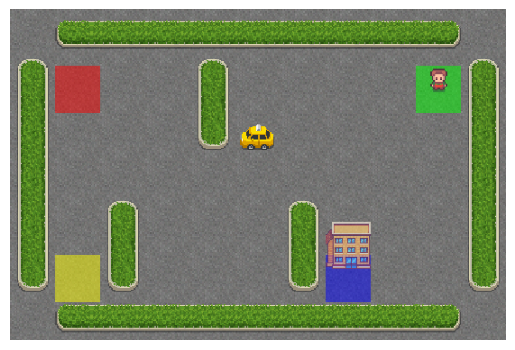

In [2]:
# Create the environment
env = gym.make("Taxi-v3", render_mode="rgb_array")

observation, info = env.reset()

frames = []

# Capture frames for 100 steps
for _ in range(100):
    action = env.action_space.sample()  # Random action
    observation, reward, terminated, truncated, info = env.step(action)  # Perform action

    frame = env.render()
    frames.append(frame)  # Save frame

    print("_____OBSERVATION SPACE_____ \n")
    print("Observation Space Shape", env.observation_space)
    print("Sample observation", env.observation_space.sample())
    print("_____________________________")

    print("\n _____ACTION SPACE_____ \n")
    print("Action Space Shape", env.action_space.n)
    print("Action Space Sample", action)

    print("__________________________________________ \n\n")

    # Reset the environment if needed
    if terminated or truncated:
        print("Environment reset!")
        observation, info = env.reset()

# Close at the end
env.close()

fig, ax = plt.subplots()
img = ax.imshow(np.zeros((400, 600, 3), dtype=np.uint8))
ax.axis('off')

def update_frame(frame):
    img.set_data(frame)
    return [img]

# Create animation
ani = animation.FuncAnimation(fig, update_frame, frames=frames, interval=100, blit=True)

# Save animation
ani.save('taxi_random.mp4', writer='ffmpeg', fps=20)

# display(fig)

# Stop the virtual display at the end
virtual_display.stop()

---
## Q-Learning

In [5]:
state_space = env.observation_space.n
print(f"Possible states: {state_space}")

action_space = env.action_space.n
print(f"Possible actions: {action_space}")

Possible states: 500
Possible actions: 6


In [6]:
q_table_taxi = initalize_q_table(state_space, action_space)
q_table_taxi.shape

(500, 6)

In [10]:
# Training parameters
n_training_episodes = 1_000_000 # Total training episodes
learning_rate = 0.7 # Learning rate

# Eval parameters
n_eval_episodes = 100  # Total episodes

# DO NOT MODIFY EVAL_SEED
eval_seed = [16,54,165,177,191,191,120,80,149,178,48,38,6,125,174,73,50,172,100,148,146,6,25,40,68,148,49,167,9,97,164,176,61,7,54,55,
 161,131,184,51,170,12,120,113,95,126,51,98,36,135,54,82,45,95,89,59,95,124,9,113,58,85,51,134,121,169,105,21,30,11,50,65,12,43,82,145,152,97,106,55,31,85,38,
 112,102,168,123,97,21,83,158,26,80,63,5,81,32,11,28,148] # Hugging Face propose seeds

# Env parameters
env_id = "Taxi-v3"  # Env
max_steps = 99 # Max steps per episode
gamma = 0.99  # Discounting rate

# Exploration parameters
max_epsilon = 1.0  # Exploration prob at start
min_epsilon = 0.05  # Min exploration prob
decay_rate = 0.005 # Exponential decay for exploration prob

---
## Training

In [16]:
q_table_taxi = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, q_table_taxi)

  0%|          | 0/1000000 [00:00<?, ?it/s]

---
## Evaluate

In [17]:
mean_reward, std_reward = evaluate_agent(env, max_steps, n_eval_episodes, q_table_taxi, eval_seed)
print(f"Mean_reward={mean_reward:.2f} +/- {std_reward:.2f}")

  0%|          | 0/100 [00:00<?, ?it/s]

Mean_reward=7.56 +/- 2.71


---
## Upload to Hugging Face HUB

In [18]:
model = {
    "env_id": env_id,
    "max_steps": max_steps,
    "n_training_episodes": n_training_episodes,
    "n_eval_episodes": n_eval_episodes,
    "eval_seed": eval_seed,
    "learning_rate": learning_rate,
    "gamma": gamma,
    "max_epsilon": max_epsilon,
    "min_epsilon": min_epsilon,
    "decay_rate": decay_rate,
    "qtable": q_table_taxi,
}

In [22]:
notebook_login()

In [23]:
username = "sbolanowski"  # FILL THIS
repo_name = "q-Taxi-v3"  # FILL THIS
push_to_hub(repo_id=f"{username}/{repo_name}", model=model, env=env)

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

.gitattributes: 0.00B [00:00, ?B/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

False


Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...29157addcc66bec7783e/q-learning.pkl: 100%|##########| 24.6kB / 24.6kB            

  ...2fb029157addcc66bec7783e/replay.mp4: 100%|##########|  126kB /  126kB            

Your model is pushed to the Hub. You can view your model here:  https://huggingface.co/sbolanowski/q-Taxi-v3



---
